In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import pickle

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from neupy import algorithms, estimators, environment, layers, plots, init
from xgboost import XGBClassifier

from RBFN import RBFN
from ensemble import AveragedNetwork

sns.set(style="whitegrid")

### Load & Merge Data

In [2]:
properties = pd.read_csv('Data/properties_2016.csv', header=0, encoding='utf-8')
train = pd.read_csv('Data/train_2016_v2.csv', parse_dates=["transactiondate"], header=0, encoding='utf-8')

merged_df = pd.merge(train,properties,on="parcelid",how="left")

print("Shape Of Dataset: ", merged_df.shape)

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape Of Dataset:  (90275, 60)


### Save Merged Data

In [3]:
merged_df.to_csv("Data/merged_2016.csv", index=False)

# Data Exploration

### Renaming the features

In [4]:
merged_df = pd.read_csv("Data/merged_2016.csv")

renamed_columns = {
    'parcelid': 'id_parcel',
    'yearbuilt': 'build_year',
    'basementsqft': 'area_basement',
    'yardbuildingsqft17': 'area_patio',
    'yardbuildingsqft26': 'area_storage_shed',
    'poolsizesum': 'area_pool',
    'lotsizesquarefeet': 'area_lot',
    'garagetotalsqft': 'area_garage',
    'finishedfloor1squarefeet': 'area_firstfloor_finished',
    'calculatedfinishedsquarefeet': 'area_total_calculated',
    'finishedsquarefeet6': 'area_finished_base',
    'finishedsquarefeet12': 'area_finished_living',
    'finishedsquarefeet13': 'area_perimeter_living',
    'finishedsquarefeet15': 'area_total',
    'finishedsquarefeet50': 'area_finished_first_floor',
    'unitcnt': 'num_unit',
    'numberofstories': 'num_story',
    'roomcnt': 'num_room',
    'bathroomcnt': 'num_bathroom',
    'bedroomcnt': 'num_bedroom',
    'calculatedbathnbr': 'num_bathroom_calculated',
    'fullbathcnt': 'num_bath',
    'threequarterbathnbr': 'num_quarter_bathroom',
    'fireplacecnt': 'num_fireplace',
    'poolcnt': 'num_pool',
    'garagecarcnt': 'num_garage',
    'regionidcounty': 'region_county',
    'regionidcity': 'region_city',
    'regionidzip': 'region_zip',
    'regionidneighborhood': 'region_neighborhood',
    'taxvaluedollarcnt': 'tax_dollar_value',
    'structuretaxvaluedollarcnt': 'tax_building',
    'landtaxvaluedollarcnt': 'tax_land',
    'taxamount': 'tax_amount',
    'assessmentyear': 'tax_assessment_year',
    'taxdelinquencyflag': 'tax_delinquency_flag',
    'taxdelinquencyyear': 'tax_delinquency_year',
    'propertyzoningdesc': 'zoning_desc',
    'propertylandusetypeid': 'zoning_landuse_type',
    'propertycountylandusecode': 'zoning_landuse_county',
    'fireplaceflag': 'flag_fireplace',
    'hashottuborspa': 'flag_tub',
    'buildingqualitytypeid': 'quality',
    'buildingclasstypeid': 'framing',
    'typeconstructiontypeid': 'material',
    'decktypeid': 'deck',
    'storytypeid': 'story',
    'heatingorsystemtypeid': 'heating',
    'airconditioningtypeid': 'aircon',
    'architecturalstyletypeid': 'architectural_style',
    'transactiondate': 'transaction_date',
    'rawcensustractandblock': 'census_tract_and_block_raw',
    'censustractandblock': 'census_tract_and_block'
}

merged_df.rename(columns=renamed_columns, inplace=True)

# convert data type of some features 
merged_df['tax_delinquency_flag'] = merged_df['tax_delinquency_flag'].apply(lambda x: 1 if x == "Y" else 0)
merged_df['flag_fireplace'] = merged_df['flag_fireplace'].apply(lambda x: 1 if x == "Y" else 0)
merged_df['flag_tub'] = merged_df['flag_tub'].apply(lambda x: 1 if x == "Y" else 0)

merged_df.describe().to_csv("data_desc.csv")
merged_df.describe()

,id_parcel,logerror,aircon,architectural_style,area_basement,num_bathroom,num_bedroom,framing,quality,num_bathroom_calculated,...,num_story,flag_fireplace,tax_building,tax_dollar_value,tax_assessment_year,tax_land,tax_amount,tax_delinquency_flag,tax_delinquency_year,census_tract_and_block
count,9.027500e+04,90275.000000,28781.000000,261.000000,43.000000,90275.000000,90275.000000,16.0,57364.000000,89093.000000,...,20570.000000,90275.0,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,90275.000000,1783.000000,8.967000e+04
mean,1.298466e+07,0.011457,1.816372,7.229885,713.581395,2.279474,3.031869,4.0,5.565407,2.309216,...,1.440739,0.0,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,0.019751,13.402692,6.049151e+13
std,2.504510e+06,0.161079,2.974168,2.716196,437.434198,1.004271,1.156436,0.0,1.900602,0.976172,...,0.544498,0.0,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,0.139143,2.715966,2.046605e+11
min,1.071174e+07,-4.605000,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,1.000000,...,1.000000,0.0,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,0.000000,6.000000,6.037101e+13
25%,1.155950e+07,-0.025300,1.000000,7.000000,407.500000,2.000000,2.000000,4.0,4.000000,2.000000,...,1.000000,0.0,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,0.000000,13.000000,6.037320e+13
50%,1.254734e+07,0.006000,1.000000,7.000000,616.000000,2.000000,3.000000,4.0,7.000000,2.000000,...,1.000000,0.0,1.320000e+05,3.428720e+05,2015.0,1.929700e+05,4542.750000,0.000000,14.000000,6.037615e+13
75%,1.422755e+07,0.039200,1.000000,7.000000,872.000000,3.000000,4.000000,4.0,7.000000,3.000000,...,2.000000,0.0,2.105345e+05,5.405890e+05,2015.0,3.454195e+05,6901.090000,0.000000,15.000000,6.059042e+13
max,1.629608e+08,4.737000,13.000000,21.000000,1555.000000,20.000000,16.000000,4.0,12.000000,20.000000,...,4.000000,0.0,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,1.000000,99.000000,6.111009e+13


### Display Features Data Type

In [5]:
pd.options.display.max_rows = 65

dtype_df = merged_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,id_parcel,int64
1,logerror,float64
2,transaction_date,object
3,aircon,float64
4,architectural_style,float64
5,area_basement,float64
6,num_bathroom,float64
7,num_bedroom,float64
8,framing,float64
9,quality,float64


### Show Frst Few Rows of Data

In [6]:
merged_df.head(3).transpose()

,0,1,2
id_parcel,11016594,14366692,12098116
logerror,0.0276,-0.1684,-0.004
transaction_date,2016-01-01,2016-01-01,2016-01-01
aircon,1,NaN,1
architectural_style,NaN,NaN,NaN
area_basement,NaN,NaN,NaN
num_bathroom,2,3.5,3
num_bedroom,3,4,2
framing,NaN,NaN,NaN
quality,4,NaN,4


### Plot the target class (shares)

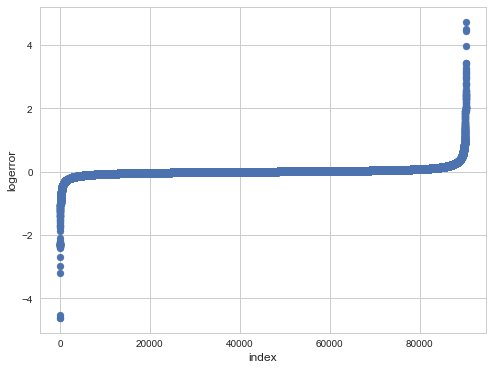

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
plt.scatter(range(merged_df.shape[0]), np.sort(merged_df['logerror'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

This looks nice with some outliers at both the ends!

Let us remove the outliers and then do a histogram plot on the same.

In [8]:
merged_df = merged_df[merged_df['logerror'] < merged_df['logerror'].quantile(.99)]
merged_df = merged_df[merged_df['logerror'] > merged_df['logerror'].quantile(.01)]

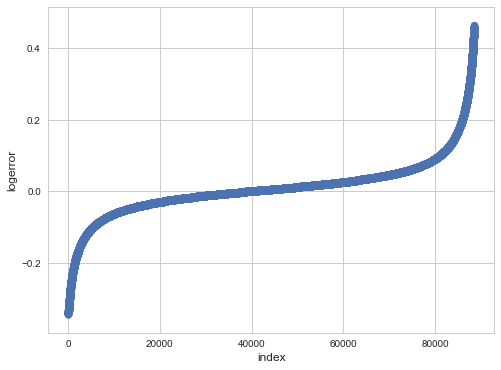

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(range(merged_df.shape[0]), np.sort(merged_df['logerror']))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

### Plot Histogram of Target Class (logerror)

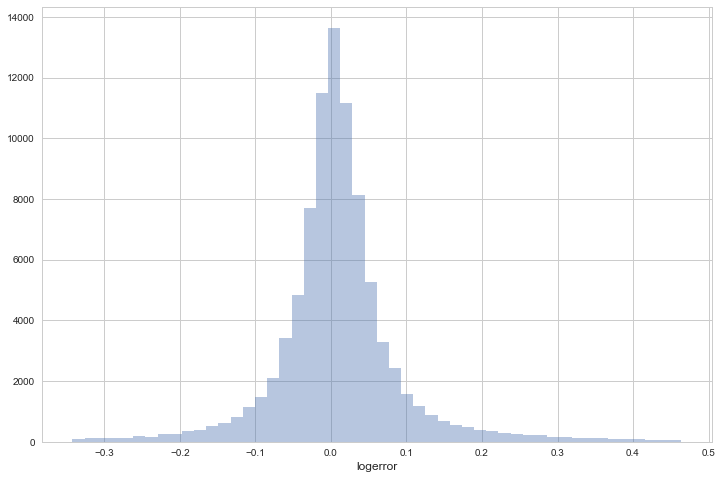

In [10]:
plt.figure(figsize=(12,8))
sns.distplot(merged_df['logerror'], bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

### More thoughts about the outcome
In fact there are two outcomes you can look at:

* logerror: log(Zestimate) - log(Saleprice). So a positive logerror means Zestimate is overestimating the Saleprice, a negative logerror means that Zestimate is underestimating Saleprice.
* absolute logerror: a small value means that log(Zestimate) is close to log(Saleprice). So, Zestimate predictions are close to Saleprice.

Any association with logerror would indicate that a feature would be associated with over- or understimating the sale price. Any association of a feature with absolute logerror would indicate that the feature is associated with a better or worse Zestimate.

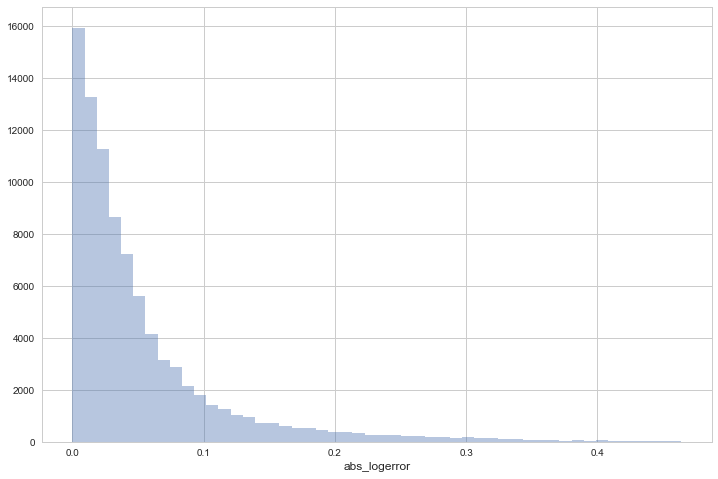

In [11]:
merged_df['abs_logerror'] = merged_df['logerror'].abs()

plt.figure(figsize=(12,8))
sns.distplot(merged_df['abs_logerror'], bins=50, kde=False)
plt.xlabel('abs_logerror', fontsize=12)
plt.show()

### Missing values

We have seen many missing values in the data peeking. How many missing values are there for each feature? In fact, some features are missing nearly completely. So, we probably have to work more with the others.

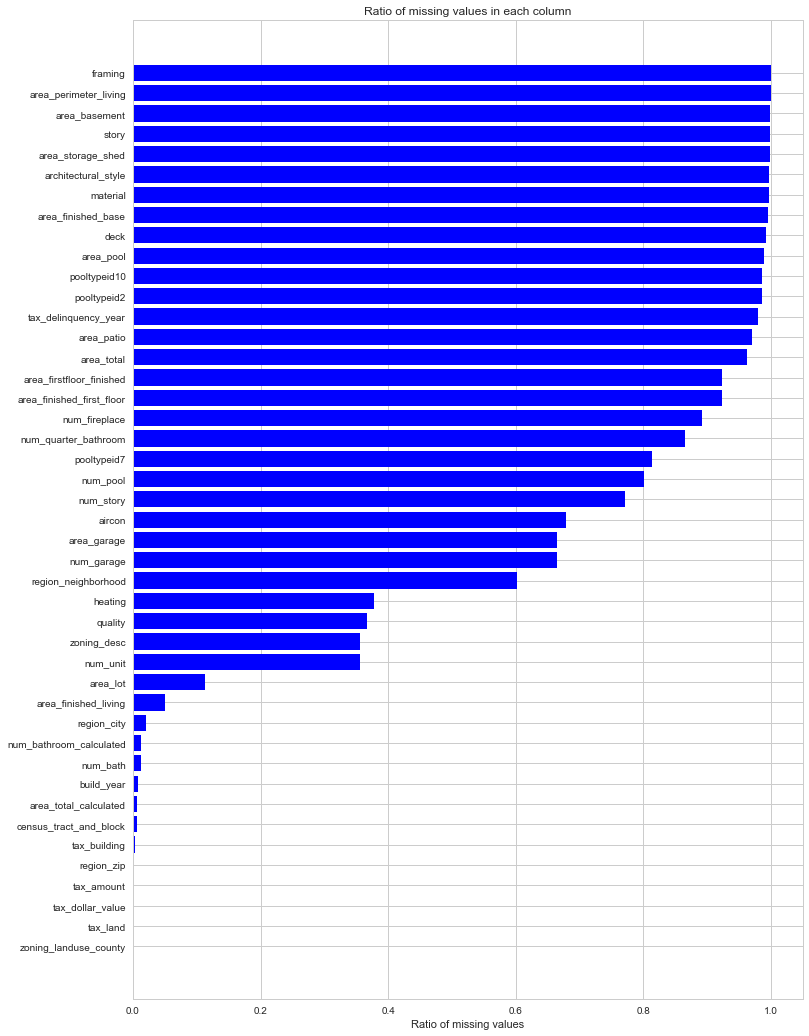

In [12]:
missing_values_df = merged_df.isnull().sum(axis=0).reset_index()
missing_values_df.columns = ['column_name', 'missing_count']
missing_values_df['missing_ratio'] = missing_values_df['missing_count'] / merged_df.shape[0]

missing_values_df = missing_values_df[missing_values_df['missing_count'] > 0]
missing_values_df = missing_values_df.sort_values(by='missing_count')

ind = np.arange(missing_values_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_values_df['missing_ratio'], color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_values_df['column_name'], rotation='horizontal')
ax.set_xlabel("Ratio of missing values")
ax.set_title("Ratio of missing values in each column")
plt.show()

### Remove features with high degree of missing values

In [13]:
removed_columns_df = missing_values_df[missing_values_df['missing_ratio'] > 0.75]
removed_columns = removed_columns_df[removed_columns_df.columns[0]].tolist()

good_features_df = merged_df.drop(removed_columns, axis=1)

print("Removed Features")
removed_columns

Removed Features


['num_story',
 'num_pool',
 'pooltypeid7',
 'num_quarter_bathroom',
 'num_fireplace',
 'area_finished_first_floor',
 'area_firstfloor_finished',
 'area_total',
 'area_patio',
 'tax_delinquency_year',
 'pooltypeid2',
 'pooltypeid10',
 'area_pool',
 'deck',
 'area_finished_base',
 'material',
 'architectural_style',
 'area_storage_shed',
 'story',
 'area_basement',
 'area_perimeter_living',
 'framing']

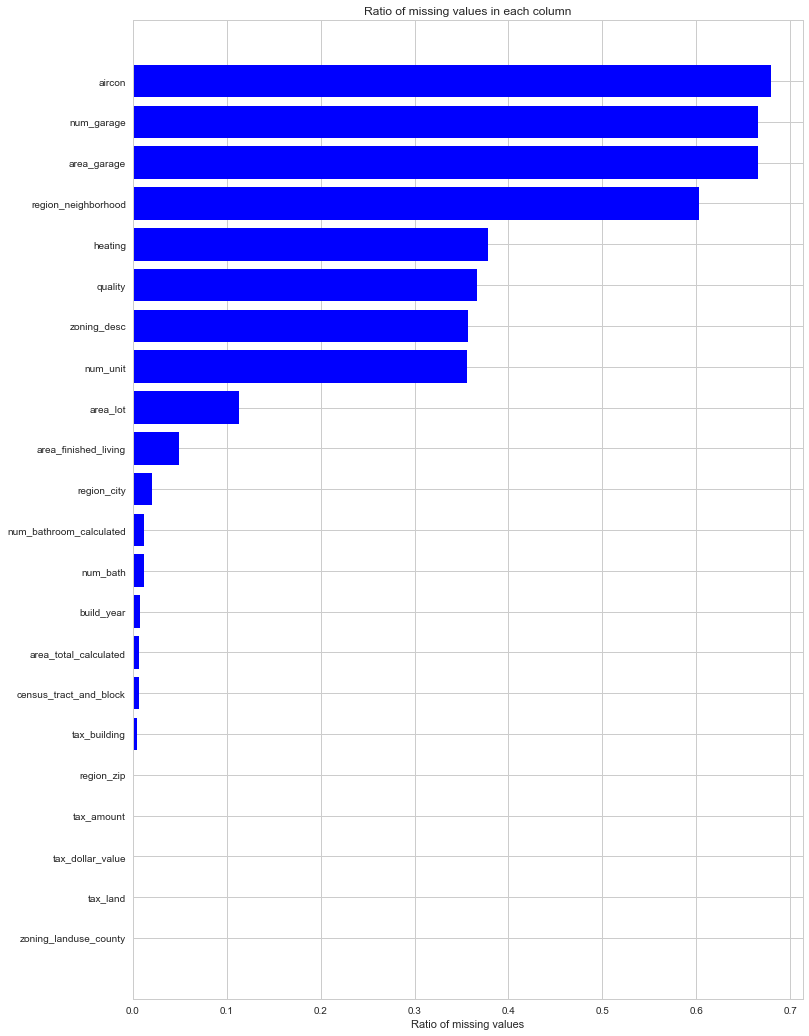

In [14]:
missing_values_df = good_features_df.isnull().sum(axis=0).reset_index()
missing_values_df.columns = ['column_name', 'missing_count']
missing_values_df['missing_ratio'] = missing_values_df['missing_count'] / merged_df.shape[0]

missing_values_df = missing_values_df[missing_values_df['missing_count'] > 0]
missing_values_df = missing_values_df.sort_values(by='missing_count')

ind = np.arange(missing_values_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_values_df['missing_ratio'], color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_values_df['column_name'], rotation='horizontal')
ax.set_xlabel("Ratio of missing values")
ax.set_title("Ratio of missing values in each column")
plt.show()

### Manual Feature Removal Engineering

In [15]:
removed_columns = [
    "id_parcel", 
    "transaction_date",
    "aircon",
    "tax_assessment_year", 
    "region_neighborhood",
    "abs_logerror"
]

good_features_df = good_features_df.drop(removed_columns, axis=1)

### Impute several missing value (N/A) with zero (0)

In [16]:
good_features_df['num_garage'] = good_features_df['num_garage'].fillna(0)
good_features_df['area_garage'] = good_features_df['area_garage'].fillna(0)
good_features_df['heating'] = good_features_df['area_garage'].fillna(0)

### Impute the rest of missing value (N/A) with Mean value

In [17]:
good_features_df = good_features_df.fillna(good_features_df.mean())

# Compute the correlation matrix

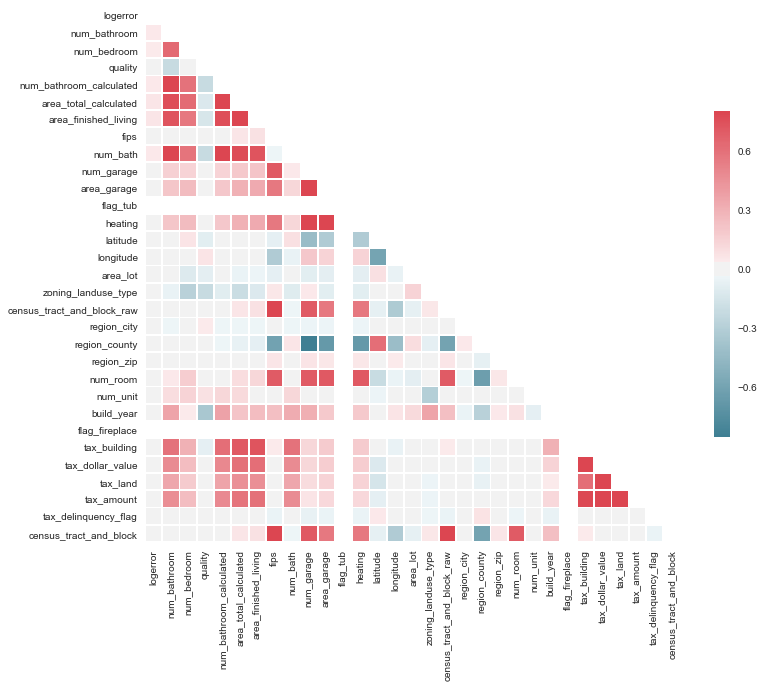

In [18]:
corr = good_features_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5})

### Remove Correlated Features

In [19]:
def remove_correlation(input_dataset, threshold):
    dataset = input_dataset.copy(deep=True)
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                colname_j = corr_matrix.columns[j] # getting the name of the other column
                col_corr.add(colname)
                if colname in dataset.columns:
                    print("Remove '{}' due to it's similarity to '{}'".format(colname, colname_j))
                    del dataset[colname] # deleting the column from the dataset

    return dataset, col_corr

In [20]:
# threshold value
correlation_threshold = 0.9

cleaned_df, removed_columns = remove_correlation(good_features_df, correlation_threshold)

removed_columns

Remove 'num_bathroom_calculated' due to it's similarity to 'num_bathroom'
Remove 'area_finished_living' due to it's similarity to 'area_total_calculated'
Remove 'num_bath' due to it's similarity to 'num_bathroom'
Remove 'heating' due to it's similarity to 'area_garage'
Remove 'census_tract_and_block_raw' due to it's similarity to 'fips'
Remove 'tax_land' due to it's similarity to 'tax_dollar_value'
Remove 'tax_amount' due to it's similarity to 'tax_dollar_value'
Remove 'census_tract_and_block' due to it's similarity to 'fips'


{'area_finished_living',
 'census_tract_and_block',
 'census_tract_and_block_raw',
 'heating',
 'num_bath',
 'num_bathroom_calculated',
 'tax_amount',
 'tax_land'}

### Compute the correlation matrix

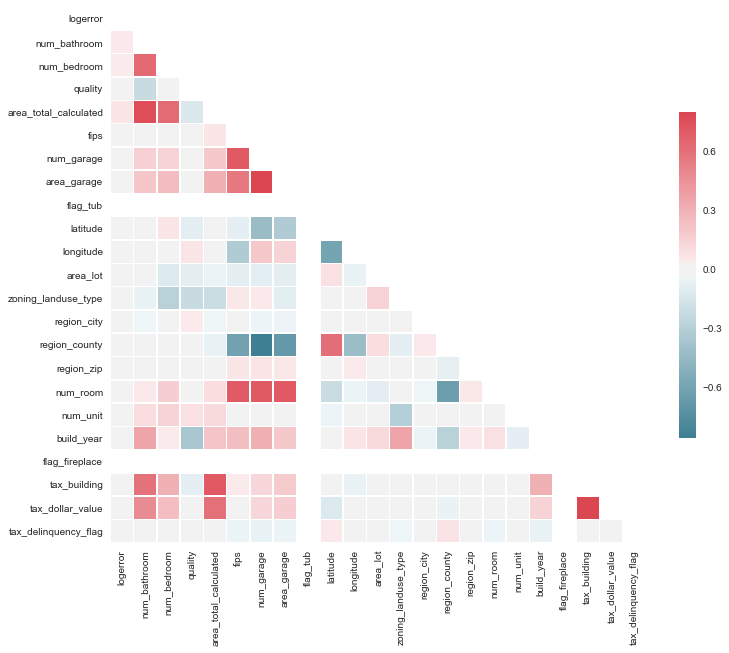

In [21]:
new_corr = cleaned_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(new_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(new_corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [22]:
def train_validate_test_split(features, target, validate_size, test_size):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = (validate_size + test_size))
    x_validate, x_test, y_validate, y_test = train_test_split(x_test, y_test, test_size = test_size / (validate_size + test_size))
    return x_train, x_validate, x_test, y_train, y_validate, y_test

In [23]:
def dataframe_split(dataframe, target_column, as_matrix=True):
    target = dataframe[target_column]
    features = dataframe.loc[:, dataframe.columns != target_column]
    if as_matrix:
        target = target.as_matrix()
        features = features.as_matrix()
    return features, target

# Feature Selection with XGBoost Feature Importance Scores

In [ ]:
environment.reproducible()

target_column = 'logerror'
xgb_df = cleaned_df.drop(["id_parcel", "transaction_date"], axis=1)

features, target = dataframe_split(xgb_df, target_column)

x_train, x_test, y_train, y_test = train_test_split(
    features,
    target.reshape((-1, 1)),
    test_size=0.3,
)

In [ ]:
# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train.ravel())

# feature importance
xgb_model.feature_importances_

### Plot Geo Location

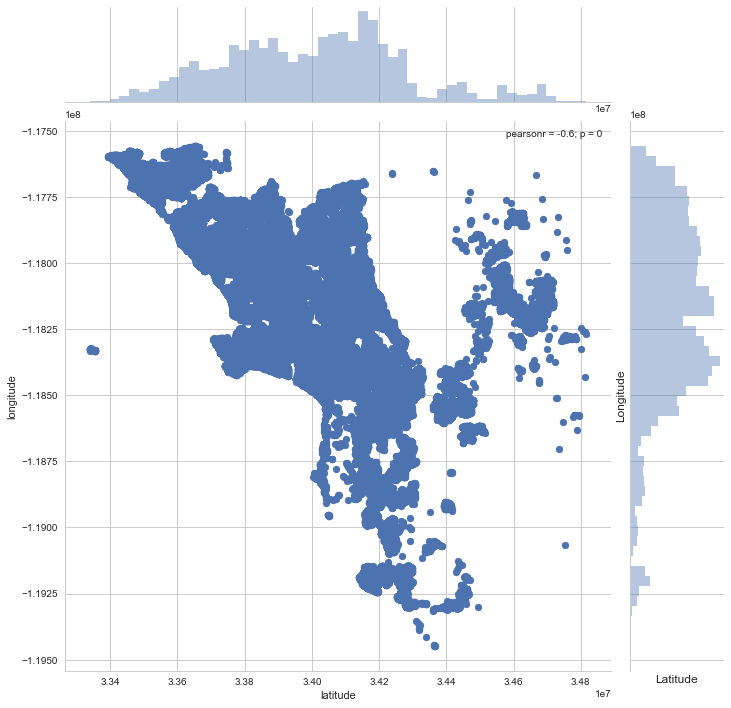

In [24]:
plt.figure(figsize=(12,12))
sns.jointplot(x=cleaned_df['latitude'], y=cleaned_df['longitude'], size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

### One-Hot Encoding for Zoning Data

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

zoning_df = cleaned_df.filter(like='zoning', axis=1)
other_df = cleaned_df.drop(zoning_df.columns.tolist(), axis=1)

zoning_df['zoning_landuse'] = zoning_df['zoning_landuse'].astype('category')

zoning_df = pd.get_dummies(zoning_df)


cleaned_df = pd.concat([other_df, zoning_df], axis=1)

cleaned_df.head(3)

# Create final dataset

In [25]:
environment.reproducible()

target_column = "logerror"

dropped_columns = [
    "latitude",
    "longitude",
    "zoning_desc", # these value could be important
    "zoning_landuse_type", # these value could be important
    "zoning_landuse_county", # these value could be important
]

final_df = cleaned_df.drop(dropped_columns, axis=1)
features, target = dataframe_split(final_df, target_column)

x_train, x_validate, x_test, y_train, y_validate, y_test = train_validate_test_split(
    preprocessing.minmax_scale(features),
    preprocessing.minmax_scale(target.reshape((-1, 1))),
    validate_size=0.15, 
    test_size=0.15,
)

num_features = x_train.shape[1]
num_target = y_train.shape[1]

### Test Neupy GRNN on our dataset

In [26]:
grnn_model = algorithms.GRNN(std=0.7, verbose=True)
grnn_model.train(x_train, y_train)

with open('grnn.pickle', 'wb') as f:
    pickle.dump(grnn_model, f)


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.7



### Evaluate the model

In [27]:
y_predicted = grnn_model.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.10432424217684386
Mean Absolute Error (0=Best, 1=Worst): 0.06680291703866531
Median Absolute Error (0=Best, 1=Worst): 0.04026497985413441


### Residual Plot

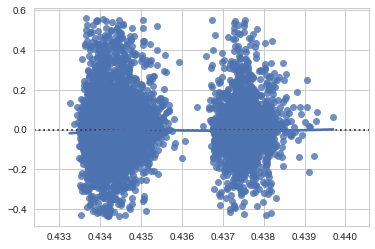

In [28]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

There is no pattern on the residual plot, that means our model decently predict the target class, since,

1. they’re pretty symmetrically distributed, tending to cluster towards the middle of the plot
2. they’re clustered around the lower single digits of the y-axis (e.g., 0.5 or 1.5, not 30 or 150)
3. in general there aren’t clear patterns

### Grid search for std parameters

In [ ]:
params = np.linspace(0.2, 0.9, 9)

best_rmse = 1
best_std = 0

for std in params:
    grnn = algorithms.GRNN(std=std, verbose=True)
    grnn.train(x_train, y_train)
    
    y_predicted = grnn.predict(x_test)
    rmse = estimators.rmse(y_predicted, y_test)
    print("RMSE {} for std {}".format(rmse, std))
    if rmse < best_rmse:
        best_rmse = rmse
        best_std = std
        
        with open('grnn.pickle', 'wb') as f:
            pickle.dump(grnn, f)
    else:
        print("Exit Grid Search")
        break

print("Best std = {} with RMSE = {}".format(best_std, best_rmse))

# Load saved GRNN model

In [ ]:
with open('grnn.pickle', 'rb') as f:
    grnn_model = pickle.load(f)
    
    y_predicted = grnn_model.predict(x_test)

In [ ]:
df_test = pd.DataFrame(np.concatenate((y_test, y_predicted), axis=1), columns={'actual_logerror', 'predicted_logerror'})
df_test.to_csv('grnn_prediction_result_best.csv', sep=',', encoding='utf-8', index=False)

# Radial Basis Function Network

In [30]:
num_features = x_train.shape[1]

rbfn_model = RBFN(input_shape = num_features, hidden_shape = num_features)
rbfn_model.train(x_train,y_train)

with open('rbfn.pickle', 'wb') as f:
    pickle.dump(rbfn_model, f)

### Evaluate the model

In [31]:
y_predicted = rbfn_model.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.11373354269141381
Mean Absolute Error (0=Best, 1=Worst): 0.07359084463923976
Median Absolute Error (0=Best, 1=Worst): 0.044328244488715085


### Residual Plot

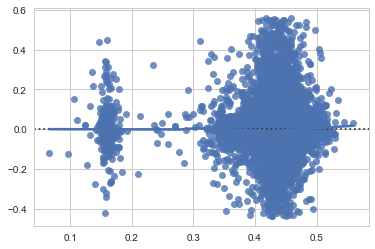

In [32]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

# Conjugate Gradient Neural Network


Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 2.06 seconds

Start training

[TRAINING DATA] shapes: (61931, 19)
[TEST DATA] shapes: (13271, 19)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |    0.010978 |     0.01092 |       1 sec |
|          25 |     0.01065 |     0.01058 |       1 sec |
|          50 |    0.010643 |    0.010576 |       1 sec |
|          75 |    0.010638

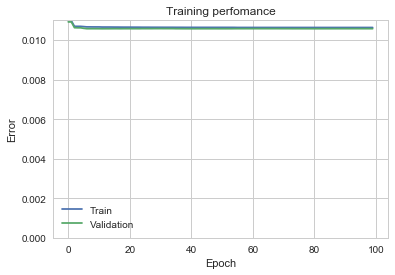

In [33]:
cgnet_model = algorithms.ConjugateGradient(
    connection=[
        layers.Input(num_features),
        layers.Sigmoid(50),
        layers.Sigmoid(num_target),
    ],
    search_method='golden',
    show_epoch=25,
    verbose=True,
    addons=[algorithms.LinearSearch],
)

cgnet_model.train(x_train, y_train, x_validate, y_validate, epochs=100)

plots.error_plot(cgnet_model)

with open('cgnet.pickle', 'wb') as f:
    pickle.dump(cgnet_model, f)

In [34]:
y_predicted = cgnet_model.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.10400964546746128
Mean Absolute Error (0=Best, 1=Worst): 0.06659879082566367
Median Absolute Error (0=Best, 1=Worst): 0.03985485410065154


### Residual Plot

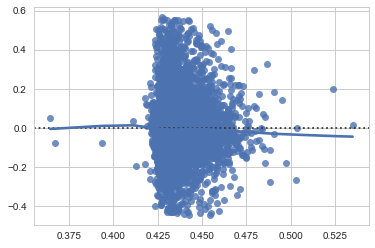

In [35]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

# Gradient Descent Network

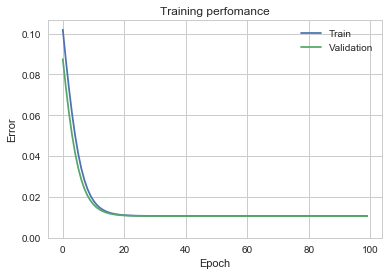

In [36]:
class Exponential(init.Initializer):
    def __init__(self, scale=0.01):
        self.scale = scale

    def sample(self, shape):
        return np.random.exponential(self.scale, size=shape)
    
gdnet_model = algorithms.GradientDescent(
    [
        layers.Input(num_features),
        layers.Sigmoid(num_features * 2, weight=Exponential(scale=0.02)),
        layers.Sigmoid(num_target, weight=Exponential(scale=0.05)),
    ]
)

gdnet_model.train(x_train, y_train, x_validate, y_validate, epochs=100)

plots.error_plot(gdnet_model)

with open('gdnet.pickle', 'wb') as f:
    pickle.dump(gdnet_model, f)

In [37]:
y_predicted = gdnet_model.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.1043393821178004
Mean Absolute Error (0=Best, 1=Worst): 0.06684874410782661
Median Absolute Error (0=Best, 1=Worst): 0.04038748703404349


### Residual Plot

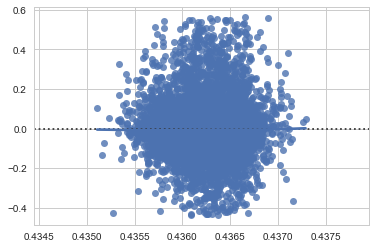

In [38]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

# Ensembled Model using average method

In [39]:
f = open('grnn.pickle', 'rb')
grnn_model = pickle.load(f)

f = open('rbfn.pickle', 'rb')
rbfn_model = pickle.load(f)

f = open('cgnet.pickle', 'rb')
cgnet_model = pickle.load(f)

f = open('gdnet.pickle', 'rb')
gdnet_model = pickle.load(f)


Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.31 seconds


In [43]:
ensemble = AveragedNetwork([grnn_model, cgnet_model, gdnet_model])

y_ensemble_predicted = ensemble.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_ensemble_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_ensemble_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_ensemble_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.10415671145839028
Mean Absolute Error (0=Best, 1=Worst): 0.06667391181782881
Median Absolute Error (0=Best, 1=Worst): 0.039855552146492945


In [44]:
with open('ensembled_network.pickle', 'wb') as f:
    pickle.dump(ensemble, f)

### Residual Plot

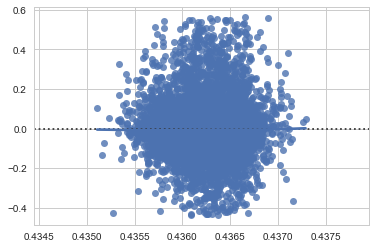

In [45]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)